In [102]:
import numpy as np
import onnxruntime
import onnx

import json
import time

# To display images on Notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

import glob
import os
from PIL import Image, ImageDraw, ImageFont
from random import randint

In [103]:
test_dir_data = '../imagenet_1k/train'
test_num = 3

../imagenet_1k/train/045/066_3281.jpg
(512, 512)
../imagenet_1k/train/844/023_3915.jpg
(512, 512)
../imagenet_1k/train/216/052_9577.jpg
(512, 512)


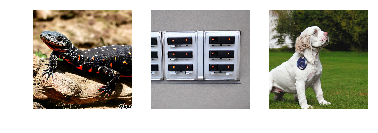

Loaded  3  inputs successfully


In [104]:
# Load inputs
inputs = []
fig, axs = plt.subplots(1,test_num)
for i in range(test_num):
    num = randint(0,999)
    input_folder = os.path.join(test_dir_data, ('00' + str(num))[-3:])
    for file in os.listdir(input_folder):
        print(os.path.join(input_folder,file))
        img = Image.open(os.path.join(input_folder,file))
        print(img.size)
        axs[i].axis('off')
        axs[i].imshow(img)
        inputs.append(img)
        
plt.show()          
print('Loaded ',test_num,' inputs successfully')

In [115]:
rs50 = onnx.load('../imagenet_1k/resnet50.onnx')
#rs50 = onnx.hub.load("ResNet50-fp32")

print('Inputs: ', rs50.graph.input)
print('Outputs: ', rs50.graph.output)

onnx.save(rs50, 'rs50.onnx')

onnx.checker.check_model(rs50)

Inputs:  [name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}
]
Outputs:  [name: "output"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 1000
      }
    }
  }
}
]


(224, 224)
(224, 224)
(224, 224)


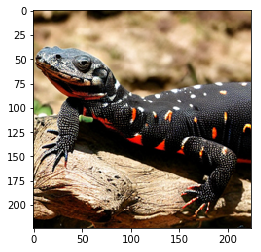

In [106]:
tmp = []

for img in inputs:
    img = img.resize((256,256))
    left = (256 - 224)/2
    top = (256 - 224)/2
    right = (256 + 224)/2
    bottom = (256 + 224)/2

    img = img.crop((left, top, right, bottom))
    
    print(img.size)

    img_array = np.array(img)
    tmp.append(img_array)

plt.imshow(tmp[0])
plt.show()

In [107]:
exp = [np.array(tmp[0].transpose(2,0,1)).astype(np.float32)]

print(np.array(exp).shape)

(1, 3, 224, 224)


In [117]:
session = onnxruntime.InferenceSession('rs50.onnx', providers = ['CPUExecutionProvider'])
result = session.run([], {'input': exp})[0]
print(f"Preprocessed data: type={result.dtype} shape={result.shape}")

Preprocessed data: type=float32 shape=(1, 1000)


In [118]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return data

labels = load_labels('../labels.txt')

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

def predict(image, raw_result):
    res = postprocess(raw_result)    

    idx = np.argmax(res)

    print('========================================')
    print('Final top prediction is: ' + str(labels[str(idx)][1]))
    print('========================================')

    sort_idx = np.flip(np.squeeze(np.argsort(res)))
    print('============ Top 5 labels are: ============================')
    print(labels[str(sort_idx[0])][1] + ',' + labels[str(sort_idx[1])][1] + ',' + labels[str(sort_idx[2])][1]
          + ',' + labels[str(sort_idx[3])][1] + ',' + labels[str(sort_idx[0])][1]) 
    print('===========================================================')

    plt.axis('off')
    display_image = plt.imshow(image)

Final top prediction is: spotlight
============ Top 5 labels are: ============================
spotlight,toilet_tissue,starfish,zebra,spotlight
[[-8.24860291e+02  2.27903809e+02 -3.46437042e+02 -8.59381104e+02
  -3.27078827e+02 -3.83289703e+02 -5.11667633e+02  2.83397293e+01
  -1.10513733e+02 -9.88616104e+01 -4.11058472e+02 -7.49755173e+01
   3.89084015e+01 -2.92729767e+02 -4.40021332e+02 -2.39606384e+02
   1.91229919e+02 -5.34152771e+02 -1.77449127e+02 -3.93390564e+02
  -5.45039856e+02 -5.47387085e+02 -5.77556702e+02  8.47141037e+01
  -1.83398041e+02 -3.78900787e+02 -8.05612427e+02 -9.94466629e+01
  -3.05949249e+02 -7.36471680e+02 -2.72044678e+02 -1.42937027e+02
  -5.18138672e+02 -6.73829712e+02 -5.23818665e+02 -7.05476135e+02
  -4.56041412e+02 -4.15175873e+02 -5.27397095e+02 -4.94351807e+02
  -7.44655075e+01 -4.70350067e+02 -2.18866608e+02 -2.56560883e+02
  -4.49515778e+02 -3.48014191e+02  3.66004944e+00 -2.53284393e+02
  -4.67298187e+02 -6.56820435e+02 -5.24671387e+02 -1.73848923e+0

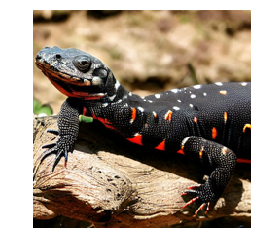

In [122]:
result = session.run([], {'input': exp})[0]
predict(tmp[0], result[0])
print(result)

Final top prediction is: spotlight
============ Top 5 labels are: ============================
spotlight,toilet_tissue,starfish,zebra,spotlight
[[-8.24860291e+02  2.27903809e+02 -3.46437042e+02 -8.59381104e+02
  -3.27078827e+02 -3.83289703e+02 -5.11667633e+02  2.83397293e+01
  -1.10513733e+02 -9.88616104e+01 -4.11058472e+02 -7.49755173e+01
   3.89084015e+01 -2.92729767e+02 -4.40021332e+02 -2.39606384e+02
   1.91229919e+02 -5.34152771e+02 -1.77449127e+02 -3.93390564e+02
  -5.45039856e+02 -5.47387085e+02 -5.77556702e+02  8.47141037e+01
  -1.83398041e+02 -3.78900787e+02 -8.05612427e+02 -9.94466629e+01
  -3.05949249e+02 -7.36471680e+02 -2.72044678e+02 -1.42937027e+02
  -5.18138672e+02 -6.73829712e+02 -5.23818665e+02 -7.05476135e+02
  -4.56041412e+02 -4.15175873e+02 -5.27397095e+02 -4.94351807e+02
  -7.44655075e+01 -4.70350067e+02 -2.18866608e+02 -2.56560883e+02
  -4.49515778e+02 -3.48014191e+02  3.66004944e+00 -2.53284393e+02
  -4.67298187e+02 -6.56820435e+02 -5.24671387e+02 -1.73848923e+0

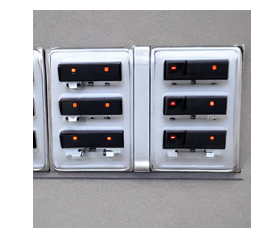

In [121]:
exp = [np.array(tmp[1].transpose(2,0,1)).astype(np.float32)]
result = session.run([], {'input': exp})[0]
predict(tmp[1], result[0])
print(result)

Final top prediction is: spotlight
============ Top 5 labels are: ============================
spotlight,toilet_tissue,starfish,zebra,spotlight


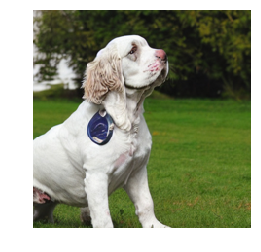

In [112]:
exp = [np.array(tmp[2].transpose(2,0,1)).astype(np.float32)]
result = session.run([], {'input': exp})[0]
predict(tmp[2], result[0])
# print(result)